In [1]:
import collections
import inspect
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

import litholog
from litholog import utils, io, defaults

In [2]:
litholog.__file__, dir(litholog)

('/home/ross/code/python/projects/litholog/litholog/__init__.py',
 ['Bed',
  'BedSequence',
  '__builtins__',
  '__cached__',
  '__doc__',
  '__file__',
  '__loader__',
  '__name__',
  '__package__',
  '__path__',
  '__spec__',
  'bed',
  'defaults',
  'io',
  'sequence',
  'utils',
  'viz',
  'wentworth'])

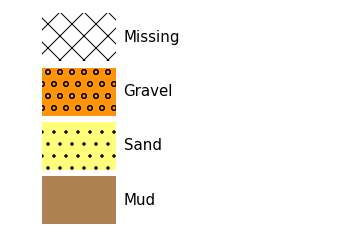

In [3]:
litholog.defaults.litholegend.plot()

In [4]:
top, base = 1, 2
data = {'lit1': 5, 'arr1': [1,2,3], 'arr2': [4,5,6]}

litholog.Bed(top, base, data)

Interval({'data': {'lit1': 5, 'arr1': [1, 2, 3], 'arr2': [4, 5, 6]}, 'top': Position({'middle': 1.0, 'units': 'm'}), 'base': Position({'middle': 2.0, 'units': 'm'}), 'description': '', 'components': []})

# Load All Sequences

Here's a function (modified from `depstrat.data`) to load all the sequences as `BedSequence`s: 

In [5]:
# Set up some default args:

FPATH = '../data/AllBedsWithProfiles_CLEAN.csv'

# Columns to convert from strings to arrays
transforms = {c : utils.string2array_pandas for c in ['depth_m', 'grain_size_mm', 'grain_size_psi']}


# binary indicators
BINARY_FEATURES = ['snd', 'shl']


# bed data columns
FLOAT_FEATURES = [
    'th',
    'gs_tops_psi',
    'mean_gs_psi',
    'max_gs_psi',
    'grain_size_psi',
    'depth_m'
]

FEATURES = BINARY_FEATURES + FLOAT_FEATURES


# Sequence-level metadata
METACOLS = ['name', 'count', 'collection', 'eod', 'eodnum', 'ng', 'ar']


# Lithology component map
COMPONENT_MAP = ('max_gs_psi', lambda gs: defaults.gs2litho(gs, units='psi'))

In [6]:
def load_sequences(
    fpath=FPATH,
    resample=None,
    depth_col='depth_m',
    features=FEATURES,
    metacols=METACOLS,
    min_length=3,
    n_load=5
):
    """
    Load the dataset from saved csv. Return list of BedSequences.
    """
    df = pd.read_csv(fpath, converters=transforms)

    bed_seqs = []
    for i, (name, grp) in enumerate(df.groupby('count')):
        seq = litholog.BedSequence.from_dataframe(
                grp,
                topcol='tops',
                thickcol='th', #basecol='bases',
                component_map=COMPONENT_MAP,
                datacols=features,
                metacols=metacols
        )
        if len(seq) >= min_length:
            bed_seqs.append(seq)
        if i > n_load:
            break

    # resample arrays if you want
    for seq in bed_seqs:
        if resample is not None:
            seq.resample_data(depth_col, resample)

    return bed_seqs

In [7]:
sequences = load_sequences(n_load=5)

# Check out a sequence

In [8]:
seq = random.choice(sequences)

seq

Striplog(31 Intervals, start=0.0, stop=19.9948)

In [9]:
seq.metadata

{'name': 'Marnoso 4',
 'count': 3,
 'collection': 'Marnoso-Arenacea',
 'eod': 'basin plain',
 'eodnum': 0,
 'ng': 0.15826064776842005,
 'ar': 0.0}

In [10]:
seq.net_to_gross

0.33537019625102554

In [11]:
seq.amalgamation_ratio

0.0

min_psi: -11
( -11 ,  -10 ,  -8 )
( -10 ,  -8 ,  -7 )
( -8 ,  -7 ,  -6 )
( -7 ,  -6 ,  -5 )
( -6 ,  -5 ,  -4 )
( -5 ,  -4 ,  -3 )
( -4 ,  -3 ,  -2 )
( -3 ,  -2 ,  -1 )
( -2 ,  -1 ,  0 )
( -1 ,  0 ,  1 )


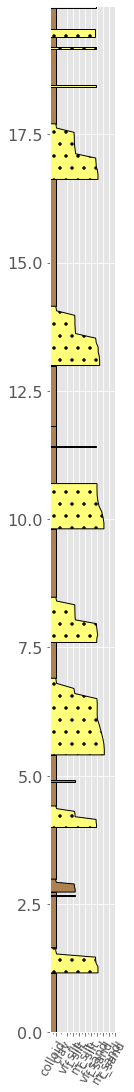

In [12]:
fig = plt.figure(figsize=(1.5, 10*1.5))
ax = fig.add_axes([0.35, 0.05, 0.6, 0.95])

ax = seq.plot(legend=defaults.litholegend, width_field='grain_size_psi', ax=ax)

min_psi: -11
( -11 ,  -10 ,  -8 )
( -10 ,  -8 ,  -7 )
( -8 ,  -7 ,  -6 )
( -7 ,  -6 ,  -5 )
( -6 ,  -5 ,  -4 )
( -5 ,  -4 ,  -3 )
( -4 ,  -3 ,  -2 )
( -3 ,  -2 ,  -1 )
( -2 ,  -1 ,  0 )
( -1 ,  0 ,  1 )


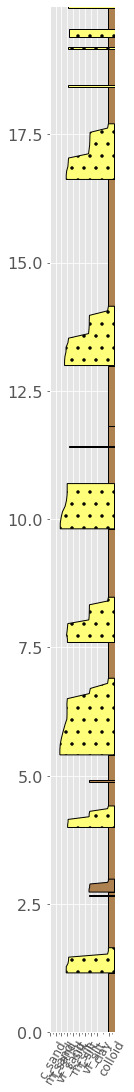

In [13]:
fig = plt.figure(figsize=(1.5, 10*1.5))
ax = fig.add_axes([0.35, 0.05, 0.6, 0.95])

ax = seq.plot(legend=defaults.litholegend, width_field='grain_size_psi', exxon_style=True, ax=ax)

min_psi: -11
( -11 ,  -8 ,  -4 )
( -8 ,  -4 ,  1 )
( -4 ,  1 ,  6 )


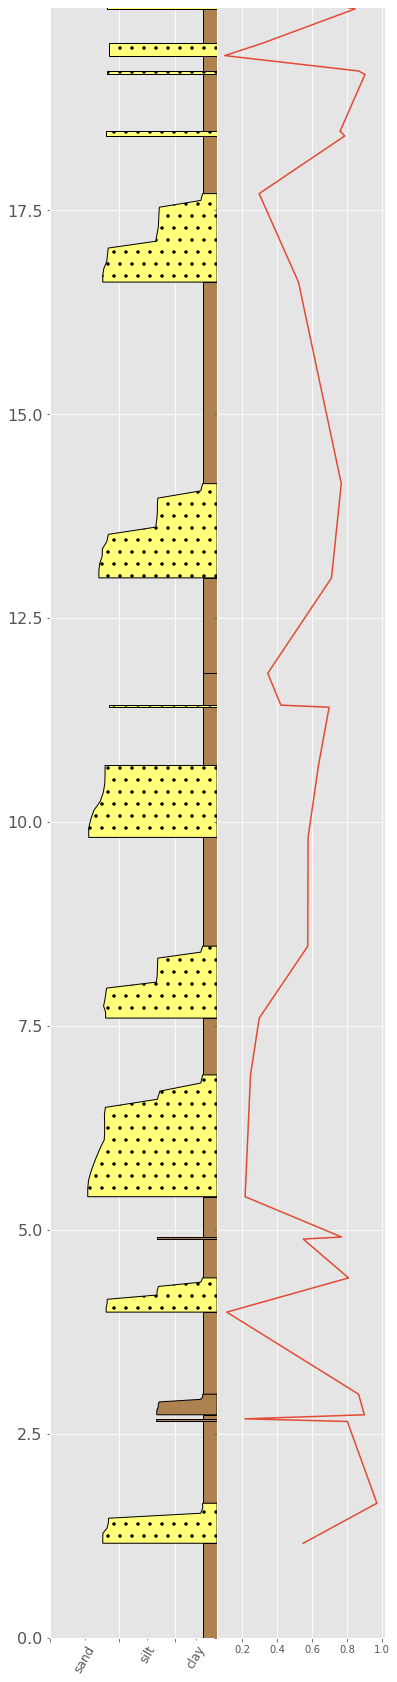

In [30]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(3*2, 10*3)) #subplot_kw=dict(frameon=False)

fig.subplots_adjust(wspace=0.)

#ax = fig.add_axes([0.35, 0.05, 0.6, 0.95])

ax1 = seq.plot(width_field='grain_size_psi', wentworth='coarse', exxon_style=True, ax=ax1)


bed_depths = [b.top.z for b in seq]
vals = [random.random() for d in bed_depths]

ax2.plot(vals, bed_depths)

In [32]:
seq[0].data

{'snd': 1.0,
 'shl': -0.0,
 'th': 0.0248800000000031,
 'gs_tops_psi': -3.1342,
 'mean_gs_psi': -3.1342,
 'max_gs_psi': -3.1342,
 'grain_size_psi': array([-3.1342, -3.1342]),
 'depth_m': array([19.9948, 19.9699])}

In [16]:
plt.show()

In [17]:
df[df.missing_tops == 1]

NameError: name 'df' is not defined

In [ ]:
plt.Axes

In [ ]:
d = {'a': 1}

In [ ]:
d.get(None)

In [ ]:
a = None; b = None;
assert a or b, 'Error'